# 応用統計課題
TTC DS+AI科１年　坂本凌太朗
## 問題設定
Bitcoinのマイニングには主にNvidia社のグラフィックボードがよく使用されています。
Bitcoinが高騰し、マイニングのためにグラフィックボードが大量に業者によって買い漁られた結果グラフィックボードまで高騰してしまった過去の背景から、BitcoinとNvidiaの株価に相関があり、Nvidiaの株価データからBitcoin価格の予測ができるのかを検証する。

## モジュールのインポート

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()
plt.rcParams["font.family"] = "Meiryo"
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.simplefilter('ignore')



## 株価、Bitcoinの価格データの取得

In [296]:
start = "2019-1-1"
end = "2023-10-31"
nvda = pdr.data.DataReader("NVDA", start, end)
btc = pdr.data.DataReader("BTC-USD", start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [297]:
# 終値を一つのデータフレームにまとめる
df = pd.DataFrame({
    "nvda": nvda["Close"],
    "btc": btc["Close"]
    })
# 取引所が空いていない日をdrop
df = df.dropna()

## 変数変換
スケールが異なるため、変数変換を行う

<Axes: xlabel='Date'>

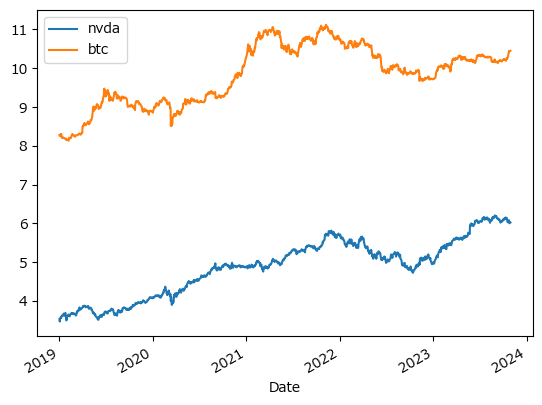

In [298]:
#logを取る
df = np.log(df)
df.plot()

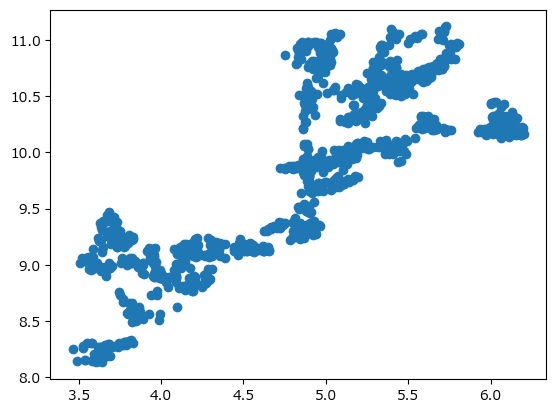

In [299]:
# 時点ごとの価格の対数列を描画
plt.scatter(df["nvda"], df["btc"])

## 回帰分析の実行

In [300]:
import statsmodels.api as sm

y_target = df["btc"]
x_target = df["nvda"]
X_target = sm.add_constant(x_target)
model = sm.OLS(y_target,X_target)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    btc   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     2338.
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          2.70e-285
Time:                        18:10:58   Log-Likelihood:                -749.10
No. Observations:                1216   AIC:                             1502.
Df Residuals:                    1214   BIC:                             1512.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7047      0.086     66.132      0.000       5.536       5.874
nvda           0.8465      0.018     48.353      0.000       0.812       0.881
==============================================================================
Omnibus:                       59.722   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.450
Skew:                           0.475   Prob(JB):                     5.52e-13
Kurtosis:                       2.539   Cond. No.                         34.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 分析結果の解釈

- NVDAの回帰係数(coef)が0.8465なので、対数総人口が1増えると対数BTC価格が0.8465増える
- NVDAの回帰整数の95%信頼区間は[[0.812, 0.881]]で0を含まないので、NVDAはBTCと関係がないと言う帰無仮説が棄却された
  - つまり NVDAはBTCと関係を持っていると結論づけられる
- 決定係数(R-squared)は0.658であるので、対数NVDAによって対数BTCの分散の65.8%が説明できる
  - 残りの分散は分析に含まれていない要因による誤差の影響である


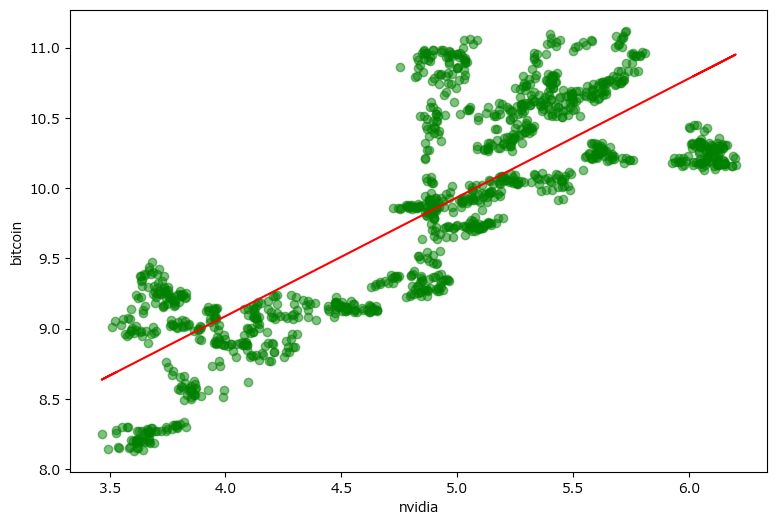

In [301]:
#回帰直線の描画
b0, b1 = res.params.round(3)
y_target_est = b0 + b1 * x_target
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot()
ax.scatter(x_target, y_target, alpha=0.5, c="g")
ax.plot(x_target, y_target_est, c="r")
ax.set_xlabel("nvidia")
ax.set_ylabel("bitcoin")
plt.show()

## 期間を分割した場合、分布がどうなるか確認


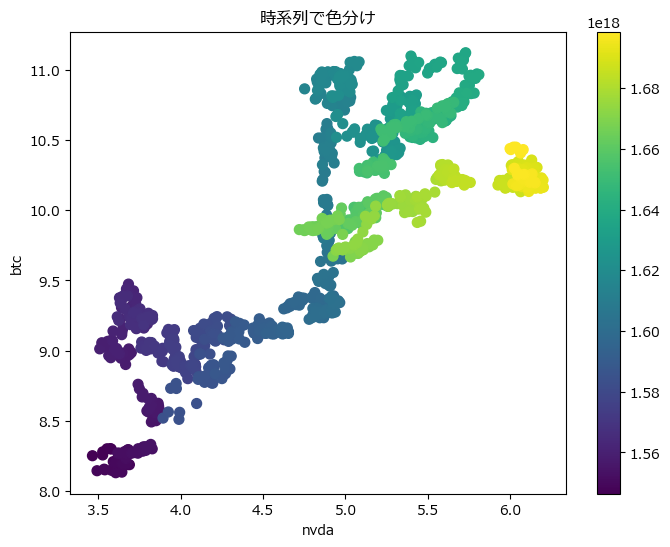

In [302]:
#時系列の推移に応じて色が変化する散布図の描画
plt.figure(figsize=(8,6))
scatter_plot = plt.scatter(x=df["nvda"], y=df["btc"], c=df.index, cmap='viridis', s=50)

colorbar = plt.colorbar(scatter_plot)
plt.xlabel('nvda')
plt.ylabel('btc')
plt.title('時系列で色分け')
plt.show()

散布図から、時系列の推移で分布が変化していることがわかる。
このことから、特定の区間で区切って回帰分析を行えば、局所的により良いモデルになるのではないかという仮説を立てることができる。
この仮説のもとに、区間を１年毎に区切ってそれぞれに回帰分析を行う。

In [303]:
# 特定の期間に絞り込む
df["y"] = 0

for n, i in enumerate(range(19, 24)):
    start_date = f"20{i}-01-01"
    end_date = f"20{i}-12-31"
    filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]
    filtered_df["y"] = n
    df.update(filtered_df)

## 区間を１年に区切って相関係数を確認


In [304]:
for i in range(5):
    r = df.query(f"y == {i}")["btc"].corr(
        df.query(f"y == {i}")["nvda"], method="pearson")
    year_ = df.query(f"y == {i}").index.year[0]
    print(f"{year_}年 相関係数 : {r}")

2019年 相関係数 : 0.22688200831240363
2020年 相関係数 : 0.773008873745926
2021年 相関係数 : 0.23484745901985513
2022年 相関係数 : 0.8702742770743033
2023年 相関係数 : 0.7184005189385912


１年間隔で期間を区切って相関係数を確認した結果、局所的に相関係数が高い年があることがわかった。

## １年毎の分布の確認

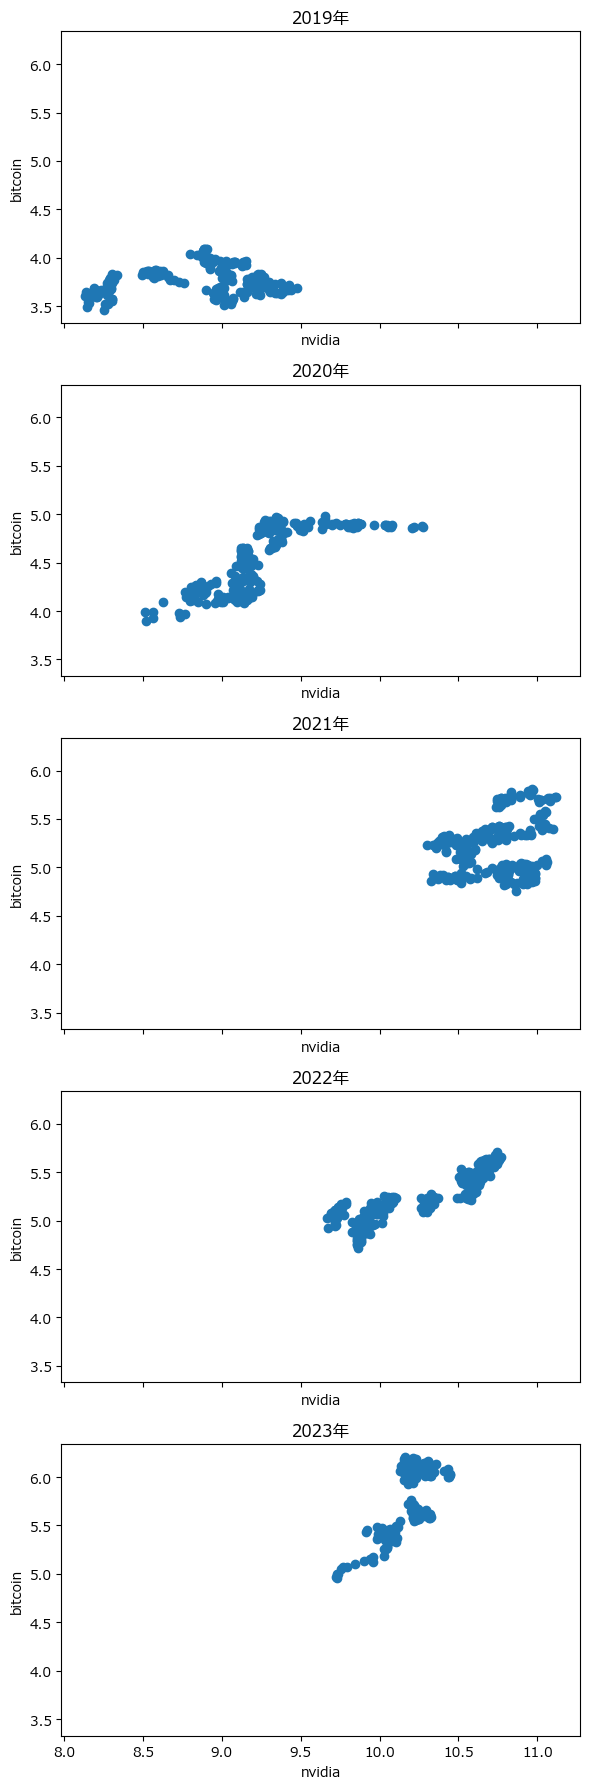

In [305]:
fig, axes = plt.subplots(5, 1, tight_layout=True,
                         figsize=(6, 18), sharex=True, sharey=True)
for i in range(5):
    year = df.query(f"y == {i}").index.year.unique().values[0]
    axes[i].scatter(df.query(f"y == {i}")["btc"], df.query(f"y == {i}")["nvda"])
    axes[i].set_title(f"{year}年")
    axes[i].set_xlabel("nvidia")
    axes[i].set_ylabel("bitcoin")

## １年毎に回帰分析の実行

2019 results
                            OLS Regression Results                            
Dep. Variable:                   nvda   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     13.57
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           0.000282
Time:                        18:11:00   Log-Likelihood:                 146.33
No. Observations:                 252   AIC:                            -288.7
Df Residuals:                     250   BIC:                            -281.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0658      0.190     16

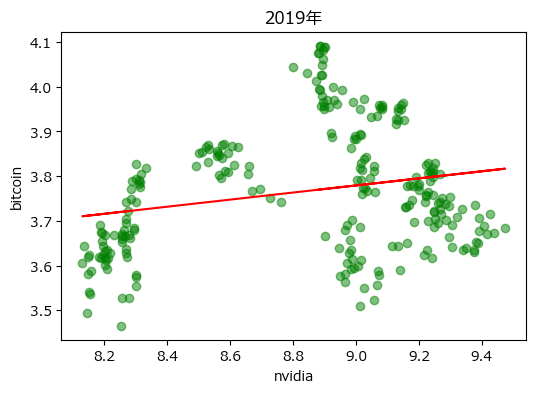

2020 results
                            OLS Regression Results                            
Dep. Variable:                   nvda   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     372.7
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           1.60e-51
Time:                        18:11:01   Log-Likelihood:                 50.399
No. Observations:                 253   AIC:                            -96.80
Df Residuals:                     251   BIC:                            -89.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2791      0.354     -6

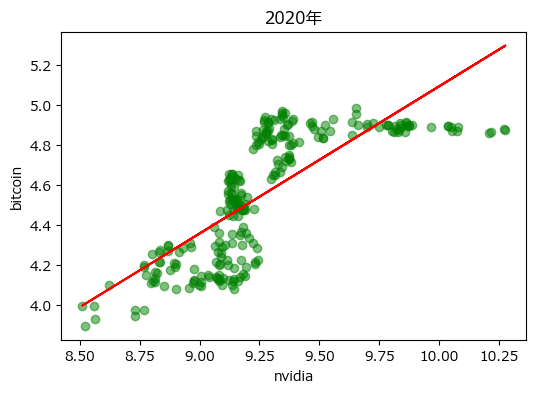

2021 results
                            OLS Regression Results                            
Dep. Variable:                   nvda   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     14.59
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           0.000168
Time:                        18:11:01   Log-Likelihood:                -35.915
No. Observations:                 252   AIC:                             75.83
Df Residuals:                     250   BIC:                             82.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8017      0.898      2

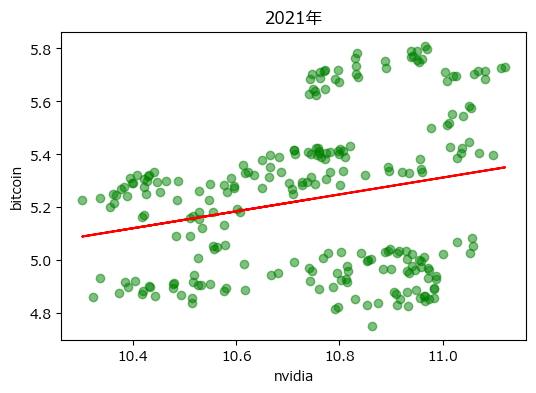

2022 results
                            OLS Regression Results                            
Dep. Variable:                   nvda   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     777.3
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           1.54e-78
Time:                        18:11:01   Log-Likelihood:                 175.96
No. Observations:                 251   AIC:                            -347.9
Df Residuals:                     249   BIC:                            -340.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8748      0.218     -4

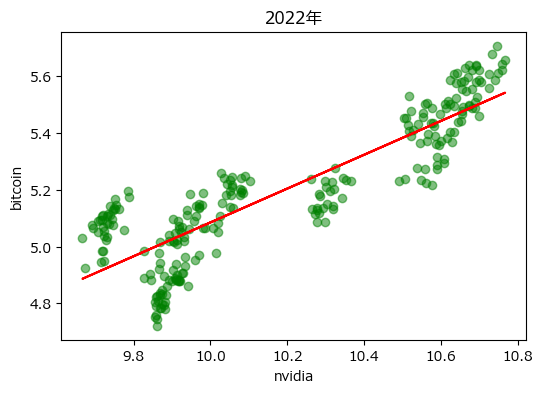

2023 results
                            OLS Regression Results                            
Dep. Variable:                   nvda   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     219.7
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           2.61e-34
Time:                        18:11:01   Log-Likelihood:                 6.8462
No. Observations:                 208   AIC:                            -9.692
Df Residuals:                     206   BIC:                            -3.017
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.3782      1.226    -10

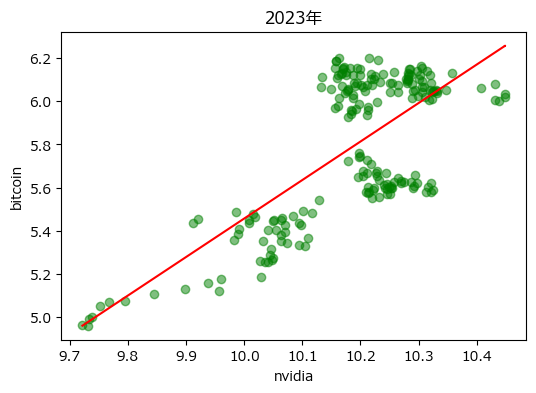

In [306]:
params = {
    "rsquareds":{},
    "b_0":{},
    "b_1":{},
    "rmse":{},
    "resid":{},
    "y_est":{}
}
for i in range(5):
    x_target = df.query(f"y == {i}")["btc"]
    y_target = df.query(f"y == {i}")["nvda"]
    X_target = sm.add_constant(x_target)
    model = sm.OLS(y_target, X_target)
    res = model.fit()
    #サマリーを表示
    year = x_target.index.year.unique().values[0]
    print(f"{year} results")
    print(res.summary())

    #各種結果の計算など
    b0 = res.params[0].round(3)
    b1 = res.params[1].round(3)
    y_target_est = res.params[0] + res.params[1] * x_target
    resid = y_target_est - y_target
    params["rsquareds"][year] = res.rsquared
    params["b_0"][year] = b0
    params["b_1"][year] = b1
    params["rmse"][year] = rmse(y_target, y_target_est)
    params["resid"][year] = resid
    params["y_est"][year] = y_target_est
\
    #回帰直線の描画
    fig = plt.figure(figsize=(6,4))
    ax = plt.subplot()
    ax.scatter(x_target, y_target, alpha=0.5, c="g")
    ax.plot(x_target, y_target_est, c="r")
    ax.set_xlabel("nvidia")
    ax.set_ylabel("bitcoin")
    ax.set_title(f"{year}年")
    plt.show()

    #残差を計算

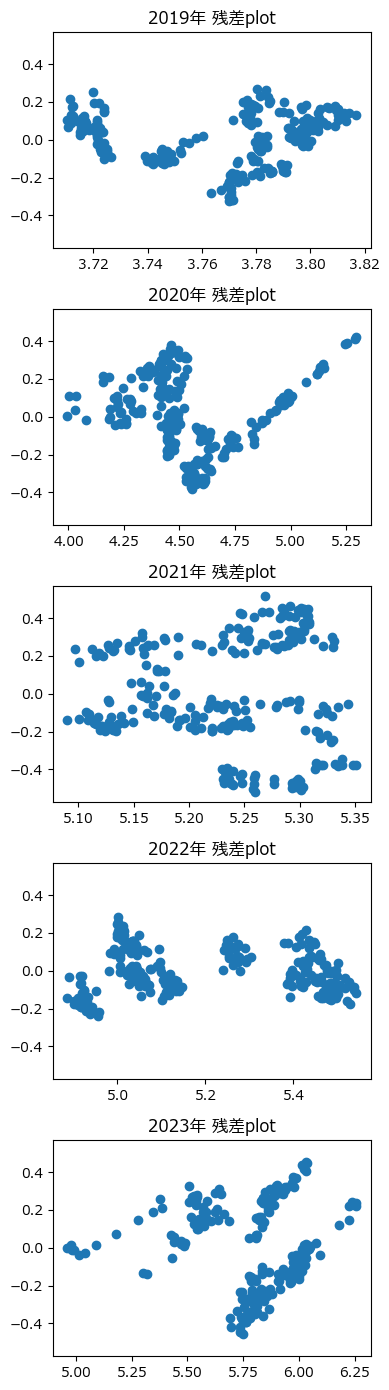

In [313]:
#年別残差プロットを描画
fig, axes = plt.subplots(5,1, tight_layout=True, figsize=(4,14), sharey=True)
for n,i in enumerate(range(2019,2024,1)):
    axes[n].scatter(params["y_est"][i], params["resid"][i])
    axes[n].set_title(f"{i}年 残差plot")


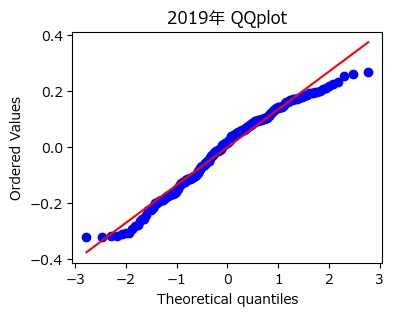

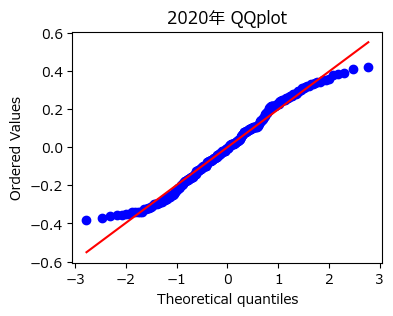

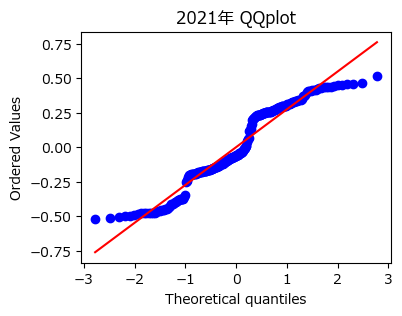

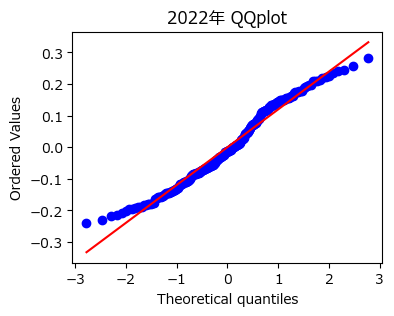

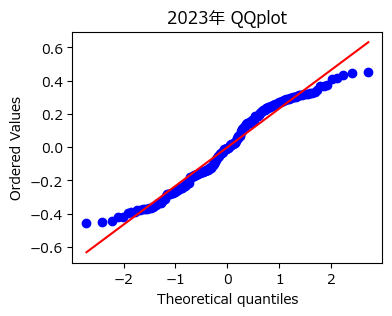

In [312]:
from scipy.stats import probplot
#年別QQプロットを表示
for n,i in enumerate(range(2019, 2024)):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot()
    probplot(params["resid"][i],plot=ax)
    ax.set_title(f"{i}年 QQplot")
    plt.show()

In [309]:
#年別決定係数
for n,i in enumerate(range(2019, 2024)):
    rsquared = params["rsquareds"][i]
    print(f"{i}年 決定係数R²: {rsquared}")


2019年 決定係数R²: 0.05147544569586926
2020年 決定係数R²: 0.5975427188899445
2021年 決定係数R²: 0.055153329008082674
2022年 決定係数R²: 0.7573773173372007
2023年 決定係数R²: 0.5160993056112372


In [310]:
#年別RMSE
for n,i in enumerate(range(2019, 2024)):
    rmse = params["rmse"][i]
    print(f"{i}年 RMSE: {rmse}")

2019年 RMSE: 0.13538913496331798
2020年 RMSE: 0.19826615316835258
2021年 RMSE: 0.2790353701421211
2022年 RMSE: 0.12003278359451534
2023年 RMSE: 0.23413606980528645


期間を絞れば、ある程度NVDAとBTCとの関係性があるとわかった。  
金融の時系列データは交絡因子が多く、１銘柄の株式で説明し切ることは難しい。  
しかし、関連性の高い変数同士であれば、特に2022年などはある程度の説明がつくことがわかる。

## 注意点

* 今回の分析に使ったデータは人口の範囲が2017年-2023年の間に限られているため、その範囲外ついて分析結果を当てはめる事はできない。
* 取引所が開いている日を対象にしているため、目的変数、説明変数ともに離散的な値である。
* 相関はある程度確認できたが、因果関係を証明できるわけではない。


## 結論

Bitcoinの価格はのNvidiaの株価によって単純な回帰でもある程度説明できる。  
金融の時系列データでも、一定の期間に区切った場合、局所的に関係性を説明できる場合がある事がわかった。  
ただし、関係性は線形ではなく、両対数変換をした値が線形の関係を持つ。  
残差は正規分布に完全に従うとは言い切れず、これは金融データは交絡因子が大きいため、説明変数が１変数のみだと説明しきれないことが原因であると考察できる。